In [1]:
# coding:utf-8
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


%matplotlib inline


In [2]:
train_user = pd.read_csv('data/table1_user',encoding='utf-8',index_col = False, delimiter='\t',
                                 )
train_user['cur_jd_type'] = train_user['cur_jd_type'].astype(str)
train_user.loc[train_user['cur_jd_type']=='nan',['cur_jd_type']] = '无业'
train_job = pd.read_csv("data/table2_jd",delimiter="\t",error_bad_lines=False)
train_action = pd.read_csv("data/table3_action",delimiter="\t")
test_action = pd.read_csv("data/zhaopin_round1_user_exposure_B_20190819",delim_whitespace=True)
test_user = pd.read_csv("data/user_ToBePredicted",delimiter="\t")
test_user['cur_jd_type'] = test_user['cur_jd_type'].astype(str)
test_user.loc[test_user['cur_jd_type']=='nan',['cur_jd_type']] = '无业'
train_action['mix_sat']  = train_action['satisfied']*10+train_action['delivered']*3
train_action.loc[train_action.mix_sat==13,'mix_sat'] =10

b'Skipping line 173315: expected 18 fields, saw 20\n'
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_big_table = pd.merge(train_action,train_user,how="inner",on="user_id")
train_big_table = pd.merge(train_big_table,train_job,how="inner",on="jd_no")
test_big_table = pd.merge(test_action,test_user,how="inner",on="user_id")
test_big_table = pd.merge(test_big_table,train_job,how="inner",on="jd_no")
train_big_table.drop_duplicates(inplace=True)
test_big_table.drop_duplicates(inplace=True)

In [4]:
train_big_table['statis_del'] = train_big_table['satisfied']
train_big_table.loc[(train_big_table['statis_del']==0)&(train_big_table['delivered']==1),['statis_del']]=0.3

In [60]:
jd_sub_series = train_big_table['jd_sub_type'].value_counts()
train_big_table.loc[train_big_table['jd_sub_type'].isin(jd_sub_series[jd_sub_series==1].index.tolist()),['jd_sub_type']]='小众'

In [61]:
test_big_table.loc[test_big_table['jd_sub_type'].isin(jd_sub_series[jd_sub_series==1].index.tolist()),['jd_sub_type']]='小众'



In [62]:
jd_sub_action_series = train_big_table.groupby(['jd_sub_type'])['browsed'].count()
jd_sub_action =pd.DataFrame({'jd_sub_type':jd_sub_action_series.index, 'jd_sub_pos_cont':jd_sub_action_series.values})
jd_sub_action['jd_sub_browsed_rate'] = train_big_table.groupby(['jd_sub_type'])['browsed'].mean().values
jd_sub_action['jd_sub_delivered_rate'] = train_big_table.groupby(['jd_sub_type'])['delivered'].mean().values
jd_sub_action['jd_sub_satisfied_rate'] = train_big_table.groupby(['jd_sub_type'])['satisfied'].mean().values
jd_sub_action['jd_sub_satisfied_cont'] = train_big_table.groupby(['jd_sub_type'])['satisfied'].sum().values
jd_sub_action['jd_sub_delivered_cont'] = train_big_table.groupby(['jd_sub_type'])['delivered'].sum().values
jd_sub_action['jd_sub_browsed_cont'] = train_big_table.groupby(['jd_sub_type'])['browsed'].sum().values
jd_sub_action['jd_sub_statis_del_rate'] = train_big_table.groupby(['jd_sub_type'])['statis_del'].mean().values
jd_sub_action['jd_sub_satisfied_conv_rate'] = jd_sub_action['jd_sub_satisfied_cont'] / jd_sub_action['jd_sub_delivered_cont']
jd_sub_action['jd_sub_delivered_conv_rate'] = jd_sub_action['jd_sub_delivered_cont'] / jd_sub_action['jd_sub_browsed_cont']
jd_sub_action.loc[jd_sub_action['jd_sub_satisfied_conv_rate'].isnull(),'jd_sub_satisfied_conv_rate']=0
jd_sub_action.loc[jd_sub_action['jd_sub_delivered_conv_rate'].isnull(),'jd_sub_delivered_conv_rate']=0
train_big_table = pd.merge(train_big_table,jd_sub_action,how="left",on="jd_sub_type")
test_big_table = pd.merge(test_big_table,jd_sub_action,how="left",on="jd_sub_type")

In [63]:
jd_sub_action[jd_sub_action['jd_sub_type'].str.contains("工")][['jd_sub_type','jd_sub_statis_del_rate']]

,jd_sub_type,jd_sub_statis_del_rate
2,CNC/数控工程师,0.000000
4,C语言开发工程师,0.000000
8,IOS开发工程师,0.000000
10,IT技术支持/维护工程师,0.033180
16,Java开发工程师,0.019355
21,万能工,0.000000
58,仪表工,0.045455
97,信息技术标准化工程师,0.000000
105,光源/照明工程师,0.000000
106,党工团干事,0.050952


In [64]:
test_big_table.loc[test_big_table['jd_sub_type']=='杂工',['jd_sub_pos_cont','jd_sub_browsed_rate','jd_sub_delivered_rate','jd_sub_satisfied_rate','jd_sub_satisfied_conv_rate','jd_sub_delivered_conv_rate','jd_sub_statis_del_rate']] = 32,0.125000,0.031250,0.031250,1.000000,0.250000,0.031250
test_big_table.loc[test_big_table['jd_sub_type']=='包装工程师',['jd_sub_pos_cont','jd_sub_browsed_rate','jd_sub_delivered_rate','jd_sub_satisfied_rate','jd_sub_satisfied_conv_rate','jd_sub_delivered_conv_rate','jd_sub_statis_del_rate']] = 9,0.333333,0.000000,0.000000,0.000000,0.500000,0.000000
test_big_table.loc[test_big_table['jd_sub_type']=='样衣工',['jd_sub_pos_cont','jd_sub_browsed_rate','jd_sub_delivered_rate','jd_sub_satisfied_rate','jd_sub_satisfied_conv_rate','jd_sub_delivered_conv_rate','jd_sub_statis_del_rate']] = 9,0.333333,0.000000,0.000000,0.000000,0.500000,0.000000
test_big_table.loc[test_big_table['jd_sub_type']=='行李员',['jd_sub_pos_cont','jd_sub_browsed_rate','jd_sub_delivered_rate','jd_sub_satisfied_rate','jd_sub_satisfied_conv_rate','jd_sub_delivered_conv_rate','jd_sub_statis_del_rate']] = 32,0.125000,0.031250,0.031250,1.000000,0.250000,0.031250

test_big_table[test_big_table['jd_sub_pos_cont'].isnull()]

,user_id,jd_no,live_city_id,desire_jd_city_id,desire_jd_industry_id,desire_jd_type_id,desire_jd_salary_id,cur_industry_id,cur_jd_type,cur_salary_id,...,jd_sub_pos_cont,jd_sub_browsed_rate,jd_sub_delivered_rate,jd_sub_satisfied_rate,jd_sub_satisfied_cont,jd_sub_delivered_cont,jd_sub_browsed_cont,jd_sub_statis_del_rate,jd_sub_satisfied_conv_rate,jd_sub_delivered_conv_rate


In [65]:
jd_sub_series = train_big_table['cur_jd_type'].value_counts()
train_big_table.loc[train_big_table['cur_jd_type'].isin(jd_sub_series[jd_sub_series==1].index.tolist()),['cur_jd_type']]='小众'
test_big_table.loc[test_big_table['cur_jd_type'].isin(jd_sub_series[jd_sub_series==1].index.tolist()),['cur_jd_type']]='小众'



In [66]:
cur_jd_action_series = train_big_table.groupby(['cur_jd_type'])['browsed'].count()
cur_jd_action =pd.DataFrame({'cur_jd_type':cur_jd_action_series.index, 'cur_jd_pos_cont':cur_jd_action_series.values})
cur_jd_action['cur_jd_browsed_rate'] = train_big_table.groupby(['cur_jd_type'])['browsed'].mean().values
cur_jd_action['cur_jd_delivered_rate'] = train_big_table.groupby(['cur_jd_type'])['delivered'].mean().values
cur_jd_action['cur_jd_satisfied_rate'] = train_big_table.groupby(['cur_jd_type'])['satisfied'].mean().values

cur_jd_action['cur_jd_statis_del_rate'] = train_big_table.groupby(['cur_jd_type'])['statis_del'].mean().values
cur_jd_action['cur_jd_satisfied_cont'] = train_big_table.groupby(['cur_jd_type'])['satisfied'].sum().values
cur_jd_action['cur_jd_delivered_cont'] = train_big_table.groupby(['cur_jd_type'])['delivered'].sum().values
cur_jd_action['cur_jd_browsed_cont'] = train_big_table.groupby(['cur_jd_type'])['browsed'].sum().values
cur_jd_action['cur_jd_satisfied_conv_rate'] = cur_jd_action['cur_jd_satisfied_cont'] / cur_jd_action['cur_jd_delivered_cont']
cur_jd_action['cur_jd_delivered_conv_rate'] = cur_jd_action['cur_jd_delivered_cont'] / cur_jd_action['cur_jd_browsed_cont']

cur_jd_action.loc[cur_jd_action['cur_jd_satisfied_conv_rate'].isnull(),'cur_jd_satisfied_conv_rate']=0
cur_jd_action.loc[cur_jd_action['cur_jd_delivered_conv_rate'].isnull(),'cur_jd_delivered_conv_rate']=0

test_big_table = pd.merge(test_big_table,cur_jd_action,how="left",on="cur_jd_type")
train_big_table = pd.merge(train_big_table,cur_jd_action,how="left",on="cur_jd_type")



In [67]:
cur_jd_action[cur_jd_action['cur_jd_type'].str.contains("商务")][['cur_jd_type','cur_jd_statis_del_rate']]

,cur_jd_type,cur_jd_statis_del_rate
37,商务专员/助理,0.03886
167,销售行政/商务,0.07067


In [68]:
test_big_table.loc[test_big_table['cur_jd_type']=='财务主管/总帐主管',['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']] = 172,0.180233,0.063953,0.023256,0.363636,0.354839,0.035465
test_big_table.loc[test_big_table['cur_jd_type']=='汽车制造',['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']] = 734,0.247956,0.141689,0.040872,0.288462,0.571429,0.071117
test_big_table.loc[test_big_table['cur_jd_type']=='首席执行官CEO/总裁/总经理',['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']] = 93,0.301075,0.118280,0.086022,0.727273,0.392857,0.095699
test_big_table.loc[test_big_table['cur_jd_type']=='储备干部',['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']] = 1785,0.243697,0.093557,0.054902,0.586826,0.383908,0.066499
test_big_table.loc[test_big_table['cur_jd_type']=='会务专员/助理',['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']] = 386,0.318653,0.038860,0.038860,1.000000,0.121951,0.03886

test_big_table.loc[test_big_table['cur_jd_type']=='化妆师/造型师/服装/道具',['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']] = train_big_table[train_big_table['jd_sub_type'].str.contains('化妆')][['cur_jd_pos_cont','cur_jd_browsed_rate','cur_jd_delivered_rate','cur_jd_satisfied_rate','cur_jd_satisfied_conv_rate','cur_jd_delivered_conv_rate','cur_jd_statis_del_rate']].values[0]
test_big_table[test_big_table['cur_jd_statis_del_rate'].isnull()]['cur_jd_type']


Series([], Name: cur_jd_type, dtype: object)

In [69]:
train_big_table['start_date'].fillna('na',inplace=True)
test_big_table['start_date'].fillna('na',inplace=True)
train_big_table['end_date'].fillna('na',inplace=True)
test_big_table['end_date'].fillna('na',inplace=True)
train_big_table['start_date'] = train_big_table['start_date'].astype(str)
train_big_table['end_date'] = train_big_table['end_date'].astype(str)
test_big_table['start_date'] = test_big_table['start_date'].astype(str)
test_big_table['end_date'] = test_big_table['end_date'].astype(str)

In [70]:
from datetime import datetime

def remain_date(x):
    if  'N' in x :
        return 99999;
    elif 'na' in x:
        return -1
    else:
        d1 = datetime.strptime('20190327', "%Y%m%d")
        d2 = datetime.strptime(x, "%Y%m%d")
        return abs((d2 - d1).days)
    
train_big_table['remain_date'] = train_big_table['end_date'].apply(remain_date)
test_big_table['remain_date'] = test_big_table['end_date'].apply(remain_date)

In [71]:
def month_convert(x):
    if  'N' in x:
        return -1;
    elif 'na' in x:
        return -1
    else:
        if int(x[0:6])< 201804:
            return '201804'
        else:
            return x[0:6]

train_big_table['start_month'] = train_big_table['start_date'].apply(month_convert)
test_big_table['start_month'] = test_big_table['start_date'].apply(month_convert)

In [72]:
def extract_city(citys,index):
    city_list = citys.split(",")
    if index < len(city_list):
        city = city_list[index]
        if city != "-":
            city = int(city)
        else:
            city = -1
    else:
        city = -1
    return city

def exp_in_desc(exp,desc):
    if str(exp) == "nan":
        exp = ""
    exps = exp.split("|")
    num = 0
    for item in exps:
        if item in desc:
            num+=1
    return num

In [73]:
min_year_dict = {
    305: 4,
    -1:-1,
    1:1,
    103:2,
    0:0,
    510:7,
    1099:10,
    399:4,
    599:7,
    199:1,
    299:2,
    110:1
}
degree_dict = {
    "初中":1,
    "中技":2,
    "高中":3,
    "中专":3,
    "大专":4,
    "本科":5,
    "硕士":6,
    "博士":7,
    "EMBA":7,
    "MBA":6,
    "其他":0,
    "请选择":0,
    "\\N":0,
    "na":0
}
min_salary_dict = {
    100002000:1000,
    400106000:4001,
    0:0,
    200104000:2001,
    600108000:6001,
    800110000:8001,
    1000115000:10001,
    2500199999:25001,
    1500125000:15001,
    3500150000:35001,
    70001100000:70001,
    1000:0,
    100001150000:100001,
    2500135000:25001,
    5000170000:50001
}
max_salary_dict = {
    100002000:2000,
    400106000:6000,
    0:0,
    200104000:4000,
    600108000:8000,
    800110000:10000,
    1000115000:15000,
    2500199999:99999,
    1500125000:25000,
    3500150000:50000,
    70001100000:100000,
    1000:1000,
    100001150000:150000,
    2500135000:35000,
    5000170000:70000
}

In [74]:
from functools import partial
def fe(df):
    df["desire_jd_city_1"] = df["desire_jd_city_id"].apply(partial(extract_city,index=0))
    df["desire_jd_city_2"] = df["desire_jd_city_id"].apply(partial(extract_city,index=1))
    df["desire_jd_city_3"] = df["desire_jd_city_id"].apply(partial(extract_city,index=2))
    df["desire_jd_city_num"] = df[["desire_jd_city_1","desire_jd_city_2","desire_jd_city_3"]].sum(axis=1)
    
    df["city_equal_desired_city_1"] = df["desire_jd_city_1"]==df["city"]
    df["city_equal_desired_city_2"] = df["desire_jd_city_2"]==df["city"]
    df["city_equal_desired_city_3"] = df["desire_jd_city_3"]==df["city"]
    
    df["work_years"] = 2019-df["start_work_date"].apply(lambda x : 2018 if x=="-" else int(x))
    
    
    df["desire_min_salary"] = df["desire_jd_salary_id"].apply(lambda x: min_salary_dict[x])
    df["desire_max_salary"] = df["desire_jd_salary_id"].apply(lambda x: max_salary_dict[x])
    df["desire_salary_diff"] = df["desire_max_salary"]-df["desire_min_salary"]
    
    df["min_years"] = df["min_years"].apply(lambda x: min_year_dict[x])
    
    df["work_years_statisfied"] = df["work_years"].astype(int) > df["min_years"]
    
    df["salary_large_than_desire"] = df["desire_min_salary"] > df["min_salary"]
    
    df["cur_salary_min"] = df["cur_salary_id"].apply(lambda x: min_salary_dict[int(x if str.isnumeric(x) else "0")])
    df["cur_salary_max"] = df["cur_salary_id"].apply(lambda x: max_salary_dict[int(x if str.isnumeric(x) else "0")])
    
    df["salary_large_than_cur"] = df["cur_salary_min"] > df["min_salary"]
    
    df["cur_degree_id"] = df["cur_degree_id"].fillna("na").apply(lambda x:degree_dict[x.strip()])
    
    df["job_description_len"] = df["job_description"].apply(len)
    
    df["experience_num"] = df["experience"].apply(lambda x: len(str(x).split("|")) if str(x) != "nan" else 0)
    
    df["min_edu_level"] = df["min_edu_level"].fillna("na").apply(lambda x:degree_dict[x.strip()])
    exp_in_desc_num = []
    for idx, data in df.iterrows():
        exp_in_desc_num.append(exp_in_desc(data["experience"],data["job_description"]))
    df["exp_in_desc_num"] = exp_in_desc_num
    
#     "live_city_id","desire_jd_salary_id","cur_industry_id","cur_jd_type","cur_salary_id",
#          "cur_degree_id","city","jd_sub_type",
#          "max_salary","min_salary","is_travel","min_years","min_edu_level",
#          "desire_jd_city_1","desire_jd_city_2","desire_jd_city_3","work_years_statisfied"
#  "jd_sub_browsed_dicret","jd_sub_delivered_dicret","jd_sub_satisfied_dicret"  
    cross_feature_tuple = [("live_city_id","city"),("live_city_id","desire_jd_city_1"),("cur_industry_id","jd_sub_type"),
                          ("cur_jd_type","jd_sub_type"),("cur_salary_id","cur_degree_id"),("city","jd_sub_type"),
                          ("jd_sub_type","min_salary"),("jd_sub_type","max_salary"),("jd_sub_type","is_travel"),
                          ("min_years","jd_sub_type"),("jd_sub_type","require_nums"),
                          ]
    cross_feature_names = list(feature[0]+"&"+feature[1] for feature in cross_feature_tuple)
    print("create cross features",cross_feature_names)
    for idx,(fa,fb) in enumerate(cross_feature_tuple):
        df[cross_feature_names[idx]] = df[fa].astype(str)+df[fb].astype(str)
    return cross_feature_names

In [75]:
cross_feature_names = fe(train_big_table)
fe(test_big_table)

create cross features ['live_city_id&city', 'live_city_id&desire_jd_city_1', 'cur_industry_id&jd_sub_type', 'cur_jd_type&jd_sub_type', 'cur_salary_id&cur_degree_id', 'city&jd_sub_type', 'jd_sub_type&min_salary', 'jd_sub_type&max_salary', 'jd_sub_type&is_travel', 'min_years&jd_sub_type', 'jd_sub_type&require_nums']
create cross features ['live_city_id&city', 'live_city_id&desire_jd_city_1', 'cur_industry_id&jd_sub_type', 'cur_jd_type&jd_sub_type', 'cur_salary_id&cur_degree_id', 'city&jd_sub_type', 'jd_sub_type&min_salary', 'jd_sub_type&max_salary', 'jd_sub_type&is_travel', 'min_years&jd_sub_type', 'jd_sub_type&require_nums']


['live_city_id&city',
 'live_city_id&desire_jd_city_1',
 'cur_industry_id&jd_sub_type',
 'cur_jd_type&jd_sub_type',
 'cur_salary_id&cur_degree_id',
 'city&jd_sub_type',
 'jd_sub_type&min_salary',
 'jd_sub_type&max_salary',
 'jd_sub_type&is_travel',
 'min_years&jd_sub_type',
 'jd_sub_type&require_nums']

In [76]:
all_big_table = pd.concat([train_big_table,test_big_table])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [77]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm as tqdm
import lightgbm as lgb

In [78]:
def feature_select(target,*df_list):
    result = []
    cat_features = ["live_city_id","desire_jd_salary_id","cur_industry_id","cur_jd_type","cur_salary_id",
         "cur_degree_id","city","jd_sub_type","start_month",
         "max_salary","min_salary","is_travel","min_years","min_edu_level",
         "desire_jd_city_1","desire_jd_city_2","desire_jd_city_3","work_years_statisfied"]+cross_feature_names
    lbl_dict = {}
    for f in cat_features:
        lbl = LabelEncoder()
        lbl.fit(all_big_table[f].astype(str))
        lbl_dict[f] = lbl
    for df in df_list:
        features = ["live_city_id","desire_jd_salary_id","cur_industry_id","cur_jd_type","cur_salary_id",
             "cur_degree_id","birthday","city","jd_sub_type","require_nums","jd_sub_statis_del_rate","cur_jd_statis_del_rate",
                    "start_month",
             "max_salary","min_salary","is_travel","min_years","min_edu_level",
             "desire_jd_city_1","desire_jd_city_2","desire_jd_city_3","exp_in_desc_num",
                   "desire_min_salary","desire_max_salary","salary_large_than_desire","cur_salary_min",
                   "cur_salary_max","salary_large_than_cur","job_description_len","experience_num","work_years_statisfied","work_years","desire_jd_city_num","desire_salary_diff"]+cross_feature_names

        x = df[features]
        if target in df.columns:
            y = df[target]
        else:
            y = None
        for f in cat_features:
            lbl = lbl_dict[f]
            x[f] = lbl.transform(x[f].astype(str))
        result.append((x,y))
    return result


In [79]:
from sklearn.model_selection import KFold

def cross_validate(param=dict(n_estimators=1000,metric="map",colsample_bytree=0.2,max_depth=7,importance_type="gain",device="gpu",gpu_platform_id=0,gpu_device_id=0)
                   ,n_folds=5,target="mix_sat"):
    train_users = train_big_table["user_id"].unique()
    folds = KFold(n_folds,shuffle=True,random_state=42)
    models = []
    test_pred = np.zeros(test_big_table.shape[0])
    scores = []
    for idx,(train_idx,valid_idx) in enumerate(folds.split(train_users)):
        t_user = train_users[train_idx]
        v_user = train_users[valid_idx]
        train_data = train_big_table[train_big_table["user_id"].isin(t_user)]
        valid_data = train_big_table[train_big_table["user_id"].isin(v_user)]
        train_group = train_data.groupby("user_id",as_index=False).count()["mix_sat"].values
        valid_group = valid_data.groupby("user_id",as_index=False).count()["mix_sat"].values
        test_group = test_big_table.groupby("user_id",as_index=False).count()["jd_no"].values
        
        result = feature_select(target,train_data,valid_data,test_big_table)
        t_x,t_y = result[0]
        v_x,v_y = result[1]
        test_x,_ = result[2]
        model = lgb.LGBMRanker(**param)
        print("Fold",idx,"-"*30)
        model.fit(t_x,t_y,group=train_group,eval_set=[(t_x,t_y),(v_x,v_y)],eval_group=[train_group,valid_group],early_stopping_rounds=100,verbose=10,
                  callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.03)]
                 )
        models.append(model)
        test_pred += model.predict(test_x)/n_folds
        scores.append(model.best_score_["valid_1"]["map@1"])
    print("mean score",np.mean(scores))
    return models,test_pred

In [80]:
train_big_table.shape

(506175, 88)

In [81]:
models,pred = cross_validate(target="mix_sat",param=dict(n_estimators=1000,metric="map",subsample=0.6,min_split_gain=10,colsample_bytree=0.6,max_depth=7,importance_type="gain",device="gpu",gpu_platform_id=0,gpu_device_id=0),n_folds=5)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold 0 ------------------------------
Training until validation scores don't improve for 100 rounds.
[10]	training's map@1: 0.257786	valid_1's map@1: 0.234705
[20]	training's map@1: 0.274194	valid_1's map@1: 0.223582
[30]	training's map@1: 0.279755	valid_1's map@1: 0.245829
[40]	training's map@1: 0.283092	valid_1's map@1: 0.250278
[50]	training's map@1: 0.292269	valid_1's map@1: 0.250278
[60]	training's map@1: 0.297831	valid_1's map@1: 0.248053
[70]	training's map@1: 0.305617	valid_1's map@1: 0.239155
[80]	training's map@1: 0.308676	valid_1's map@1: 0.246941
[90]	training's map@1: 0.314516	valid_1's map@1: 0.244716
[100]	training's map@1: 0.317019	valid_1's map@1: 0.242492
[110]	training's map@1: 0.319244	valid_1's map@1: 0.242492
[120]	training's map@1: 0.322581	valid_1's map@1: 0.234705
[130]	training's map@1: 0.327586	valid_1's map@1: 0.243604
Early stopping, best iteration is:
[36]	training's map@1: 0.28198	valid_1's map@1: 0.253615
Fold 1 ------------------------------
Training un

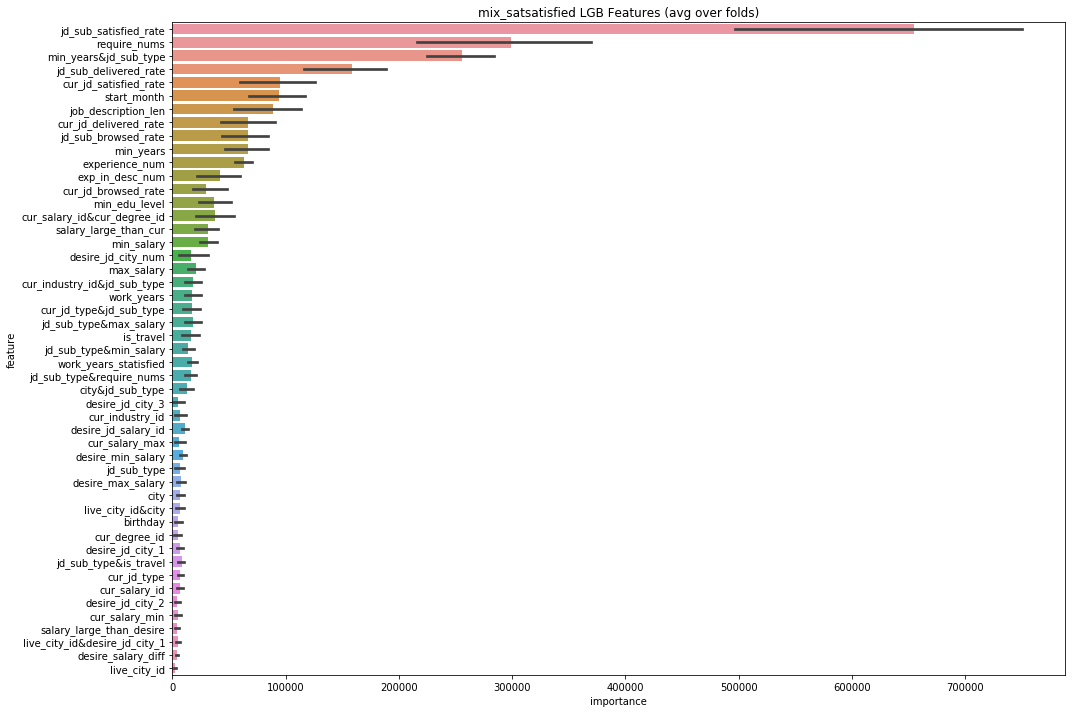

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame()
for idx,model in enumerate(models):
    fold_importance = pd.DataFrame()
    fold_importance["feature"] =["live_city_id","desire_jd_salary_id","cur_industry_id","cur_jd_type","cur_salary_id",
             "cur_degree_id","birthday","city","jd_sub_type","require_nums","cur_jd_browsed_rate",
                    "cur_jd_delivered_rate","cur_jd_satisfied_rate",
                    "jd_sub_browsed_rate",
                    "jd_sub_delivered_rate","jd_sub_satisfied_rate",
                    "start_month",
             "max_salary","min_salary","is_travel","min_years","min_edu_level",
             "desire_jd_city_1","desire_jd_city_2","desire_jd_city_3","exp_in_desc_num",
                   "desire_min_salary","desire_max_salary","salary_large_than_desire","cur_salary_min",
                   "cur_salary_max","salary_large_than_cur","job_description_len","experience_num","work_years_statisfied","work_years","desire_jd_city_num","desire_salary_diff"]+cross_feature_names

    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = idx
    feature_importance = pd.concat([feature_importance,fold_importance])
plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False));
plt.title('mix_satsatisfied LGB Features (avg over folds)');

In [82]:
test_action = pd.read_csv("data/zhaopin_round1_user_exposure_B_20190819",delim_whitespace=True)
test_action.head()

,user_id,jd_no
0,167827d429af352a93b28666c33ed0fd,6855780caa3e8b4c6c65adfacdda5282
1,167827d429af352a93b28666c33ed0fd,20603e8eec8f4fbab757ad70e86fdec2
2,167827d429af352a93b28666c33ed0fd,b612c4ec69756fe4944071cb0525ef8d
3,167827d429af352a93b28666c33ed0fd,0558a2371bbfa13eb9295f8011eeb997
4,167827d429af352a93b28666c33ed0fd,fde5a7db457d1123f56be0e295576c0c


In [83]:
submit = test_big_table[["user_id","jd_no"]]
submit["score"] = pred
submit = submit.reset_index(drop=True)
result = pd.merge(test_action,submit,how="left",on=["user_id","jd_no"])
result.fillna(-100,inplace=True)
result = result.groupby("user_id",as_index=False).apply(lambda x:x.sort_values("score",ascending=False))
result[["user_id","jd_no","score"]].to_csv("submission2.csv",index=False)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [84]:
submit = test_big_table[["user_id","jd_no"]]
submit["score"] = pred
submit = submit.reset_index(drop=True)
result = pd.merge(test_action,submit,how="left",on=["user_id","jd_no"])
result.fillna(-100,inplace=True)
result = result.groupby("user_id",as_index=False).apply(lambda x:x.sort_values("score",ascending=False))
# 需要对结果进行去重
result[["user_id","jd_no","score"]].drop_duplicates().to_csv("submission2.csv",index=False)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [85]:
result[["user_id","jd_no","score"]].drop_duplicates().shape

(29674, 3)

In [ ]:
#work_years_statisfied=1
#is_edu_ok？ 1
#year&is_city_eq 